# Hollin Hill LF-DAS
## Part 1: Data processing workflow

Susanne Ouellet, PhD candidate at University of Calgary

- email: *susanne.ouellet2@ucalgary.ca*
- Github repository: *https://github.com/smouellet/hhdas/*

Notebook to outline the processing steps to process low frequency (1Hz) DAS data beginning with 50Hz H5 files obtained from OptaSense DxS software. 
Data products: strain, strain rate, inferred displacement

In [248]:
# Import necessary packages

import h5py
import obspy
from obspy import UTCDateTime
from datetime import datetime
import pandas as pd
import numpy as np
import os, glob
import matplotlib.pyplot as plt
from scipy import signal

import zarr
import xarray as xr


In [249]:
pwd

'/Users/souellet/research/hollinhill'

In [250]:
def lf_h5tozarr(flist,chstart,chend):
    
    '''
    This function takes a file list of 50Hz raw h5 DAS files and outputs as downsampled 1Hz data using an
    IIR Chebyshev filter of order 4 (signal.scipy.decimate).
    
    Inputs:
    
    flist --> List of files containing 50Hz raw h5 DAS data
    chstart --> Start channel (must correspond to folder naming)
    chend --> End channel (must correspond to folder naming)
    
    '''
    
    ncha = chend - chstart + 1

    #Filtering
    dec_factor = 50
    lfdir = 'LFDAS_zarr_ch' + str(chstart) + '-' + str(chend) + '/'        # create subfolder

    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("working on ... ", lfdir)
    print("start time: ", current_time)

    # TIGHT-BUFFERED
    for file in flist:

        with h5py.File(file, 'r') as f: 
            raw_data = f['Acquisition']['Raw[0]']['RawData'][:]
            raw_time = f['Acquisition']['Raw[0]']['RawDataTime'][:]
            datetime_UTC = [obspy.UTCDateTime(each/1e6) for each in raw_time] # trying to move away from Obspy for plotting purposes
            t0 = datetime_UTC[0]
            te = datetime_UTC[-1]

            nsamples = len(raw_time) 
            nsamples_dec = int(nsamples/dec_factor)

            arr = np.zeros((ncha,nsamples))
            timearr = np.zeros((nsamples_dec))
            raw_dec = np.zeros((ncha,nsamples_dec))
            arr[:,:] = raw_data
            timearr[:] = np.linspace(raw_time[0],raw_time[-1],nsamples_dec)

            schunks=int(nsamples_dec/10)                  # chunk size (for dask array, hdf5)

            for ch in range(ncha):    
                # loop through channels in file (100)
                arr[ch,:] = raw_data[ch,:]        
                # decimation by a factor of 50 - 50Hz to 1Hz. Use filter order of 4 with iir   
                raw_dec[ch,:] = signal.decimate(arr[ch,:], dec_factor,n=4,ftype='iir') 
               # add preprocessed waveform data to zarr file
                filename = "lfdas_1Hz_iir_" + "ch_" + str(chstart) + '_to_' + str(chend) + '_' + str(t0) + '_to_' + str(te) + '.zarr' 

        grp = zarr.group('prepro/' + lfdir + filename)
        wf = grp.create_dataset("wf",data=raw_dec,chunks=(ncha,schunks),overwrite=True)
        time = grp.create_dataset('time',data=timearr,chunks=(schunks),overwrite=True)

    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")

    print("end time:", current_time)
    print("")
    
    return timearr,raw_dec


### Downsample to 1Hz with low pass IIR filter
Decimation of h5 dataset from 50 Hz to 1 Hz with built-in antialiasing filter (signal.decimate)


In [251]:
##############################
#### DECIMATE TO 1Hz #########
##############################

# folder names
rawdir_L1 = '/Users/souellet/research/hollinhill/rawdata/jan/ch1058-1193/' 
rawdir_L2 = '/Users/souellet/research/hollinhill/rawdata/jan/ch1208-1356/' 
rawdir_L3 = '/Users/souellet/research/hollinhill/rawdata/jan/ch1366-1494/' 
rawdir_L4 = '/Users/souellet/research/hollinhill/rawdata/jan/ch1500-1641/' 
rawdir_L5 = '/Users/souellet/research/hollinhill/rawdata/jan/ch1656-1794/' 
rawdir_L6 = '/Users/souellet/research/hollinhill/rawdata/jan/ch0861-1001/' 

# Start and end channels (must correspond with folder naming)
chstart_L1 = 1058
chend_L1 = 1193

chstart_L2 = 1208
chend_L2 = 1356
 
chstart_L3 = 1366
chend_L3 = 1494 

chstart_L4 = 1500
chend_L4 = 1641 

chstart_L5 = 1656
chend_L5 = 1794 

chstart_L6 = 861
chend_L6 = 1001 

# DOWNSAMPLE TO 1HZ FROM 50HZ - TAKES ~25 MINUTES TO RUN CELL (processing all 6 lines, ~4-5 minutes per line)_

flist_L1 = sorted(glob.glob(rawdir_L1 + '*.h5'))  # list of all h5 files  
timearr_L1, raw_dec_L1 = lf_h5tozarr(flist_L1,chstart_L1,chend_L1)

flist_L2 = sorted(glob.glob(rawdir_L2 + '*.h5'))  # list of all h5 files  
timearr_L2, raw_dec_L2 = lf_h5tozarr(flist_L2,chstart_L2,chend_L2)

flist_L3 = sorted(glob.glob(rawdir_L3 + '*.h5'))  # list of all h5 files  
timearr_L3, raw_dec_L3 = lf_h5tozarr(flist_L3,chstart_L3,chend_L3)

flist_L4 = sorted(glob.glob(rawdir_L4 + '*.h5'))  # list of all h5 files  
timearr_L4, raw_dec_L4 = lf_h5tozarr(flist_L4,chstart_L4,chend_L4)

flist_L5 = sorted(glob.glob(rawdir_L5 + '*.h5'))  # list of all h5 files  
timearr_L5, raw_dec_L5 = lf_h5tozarr(flist_L5,chstart_L5,chend_L5)

flist_L6 = sorted(glob.glob(rawdir_L6 + '*.h5'))  # list of all h5 files  
timearr_L6, raw_dec_L6 = lf_h5tozarr(flist_L6,chstart_L6,chend_L6)


working on ...  LFDAS_zarr_ch1058-1193/
start time:  16:52:46
end time: 16:56:42

working on ...  LFDAS_zarr_ch1208-1356/
start time:  16:56:42
end time: 17:00:41

working on ...  LFDAS_zarr_ch1366-1494/
start time:  17:00:42
end time: 17:04:19

working on ...  LFDAS_zarr_ch1500-1641/
start time:  17:04:19
end time: 17:08:14

working on ...  LFDAS_zarr_ch1656-1794/
start time:  17:08:14
end time: 17:12:04

working on ...  LFDAS_zarr_ch861-1001/
start time:  17:12:04
end time: 17:15:57



In [252]:
# ZARR DIRECTORIES TO 1HZ LF-DAS DATA

lfdir_L1 = 'LFDAS_zarr_ch' + str(chstart_L1) + '-' + str(chend_L1) + '/'        
zarrlist_L1 = sorted(glob.glob('prepro/' + lfdir_L1 + '*iir*' + str(chstart_L1) + '*.zarr')) 

lfdir_L2 = 'LFDAS_zarr_ch' + str(chstart_L2) + '-' + str(chend_L2) + '/'        
zarrlist_L2 = sorted(glob.glob('prepro/' + lfdir_L2 + '*iir*' + str(chstart_L2) + '*.zarr'))

lfdir_L3 = 'LFDAS_zarr_ch' + str(chstart_L3) + '-' + str(chend_L3) + '/'        
zarrlist_L3 = sorted(glob.glob('prepro/' + lfdir_L3 + '*iir*' + str(chstart_L3) + '*.zarr')) 

lfdir_L4 = 'LFDAS_zarr_ch' + str(chstart_L4) + '-' + str(chend_L4) + '/'        
zarrlist_L4 = sorted(glob.glob('prepro/' + lfdir_L4 + '*iir*' + str(chstart_L4) + '*.zarr')) 

lfdir_L5 = 'LFDAS_zarr_ch' + str(chstart_L5) + '-' + str(chend_L5) + '/'        
zarrlist_L5 = sorted(glob.glob('prepro/' + lfdir_L5 + '*iir*' + str(chstart_L5) + '*.zarr')) 

lfdir_L6 = 'LFDAS_zarr_ch' + str(chstart_L6) + '-' + str(chend_L6) + '/'        
zarrlist_L6 = sorted(glob.glob('prepro/' + lfdir_L6 + '*iir*' + str(chstart_L6) + '*.zarr')) 


### Convert to units of strain
Reshape arrays to 2x2 matrix (no. channels, no. seconds) 

In [253]:
############################################################
### INPUT PARAMETERS FOR STRAIN CONVERSION ################
############################################################

n_tb = 1.468 # for G.657.A1 SM fiber at 1550 nm
L = 4.0838094 # gauge length
l = 1550.12 * 1e-9 # optical wavelength

nsamples = 60 # OptaSense output in 1-minute (60 second) files. 

# 1-minute files - number of minutes per FO section
nmins_L1 = len(zarrlist_L1)     
nmins_L2 = len(zarrlist_L2)     
nmins_L3 = len(zarrlist_L3)     
nmins_L4 = len(zarrlist_L4)     
nmins_L5 = len(zarrlist_L5)     
nmins_L6 = len(zarrlist_L6)     

# number of channels per FO section
ncha_L1 = chend_L1 - chstart_L1 + 1
ncha_L2 = chend_L2 - chstart_L2 + 1
ncha_L3 = chend_L3 - chstart_L3 + 1
ncha_L4 = chend_L4 - chstart_L4 + 1
ncha_L5 = chend_L5 - chstart_L5 + 1
ncha_L6 = chend_L6 - chstart_L6 + 1

# low frequency numpy array initialization
lfarr_L1 = np.zeros((nmins_L1,ncha_L1,nsamples))
lfarr_L2 = np.zeros((nmins_L2,ncha_L2,nsamples))
lfarr_L3 = np.zeros((nmins_L3,ncha_L3,nsamples))
lfarr_L4 = np.zeros((nmins_L4,ncha_L4,nsamples))
lfarr_L5 = np.zeros((nmins_L5,ncha_L5,nsamples))
lfarr_L6 = np.zeros((nmins_L6,ncha_L6,nsamples))

# low frequency numpy array initialization
time_L1 = np.zeros((nmins_L1,nsamples))
time_L2 = np.zeros((nmins_L2,nsamples))
time_L3 = np.zeros((nmins_L3,nsamples))
time_L4 = np.zeros((nmins_L4,nsamples))
time_L5 = np.zeros((nmins_L5,nsamples))
time_L6 = np.zeros((nmins_L6,nsamples))

for i,file in enumerate(zarrlist_L1): 
    zarrty = zarr.open(file, mode='r')    # DO NOT USE 'w' --> CAN ERASE EVERYTHING IN FOLDER. PROCEED WITH CAUTION
    lfarr_L1[i,:,:] = zarrty.wf[:,:]
    time_L1[i,:] = zarrty.time[:]

for i,file in enumerate(zarrlist_L2): 
    zarrty = zarr.open(file, mode='r')    # DO NOT USE 'w' --> CAN ERASE EVERYTHING IN FOLDER. PROCEED WITH CAUTION
    lfarr_L2[i,:,:] = zarrty.wf[:,:]
    time_L2[i,:] = zarrty.time[:]

for i,file in enumerate(zarrlist_L3): 
    zarrty = zarr.open(file, mode='r')    # DO NOT USE 'w' --> CAN ERASE EVERYTHING IN FOLDER. PROCEED WITH CAUTION
    lfarr_L3[i,:,:] = zarrty.wf[:,:]
    time_L3[i,:] = zarrty.time[:]
    
for i,file in enumerate(zarrlist_L4): 
    zarrty = zarr.open(file, mode='r')    # DO NOT USE 'w' --> CAN ERASE EVERYTHING IN FOLDER. PROCEED WITH CAUTION
    lfarr_L4[i,:,:] = zarrty.wf[:,:]
    time_L4[i,:] = zarrty.time[:]
    
for i,file in enumerate(zarrlist_L5): 
    zarrty = zarr.open(file, mode='r')    # DO NOT USE 'w' --> CAN ERASE EVERYTHING IN FOLDER. PROCEED WITH CAUTION
    lfarr_L5[i,:,:] = zarrty.wf[:,:]
    time_L5[i,:] = zarrty.time[:]
    
for i,file in enumerate(zarrlist_L6): 
    zarrty = zarr.open(file, mode='r')    # DO NOT USE 'w' --> CAN ERASE EVERYTHING IN FOLDER. PROCEED WITH CAUTION
    lfarr_L6[i,:,:] = zarrty.wf[:,:]
    time_L6[i,:] = zarrty.time[:]
    
############################
### STRAIN CONVERSION L1 ###
############################

lfarrs_L1 = lfarr_L1 * (2*np.pi)/2**16           # Convert to units of radians 
lfarrs_L1 *= l/(0.78 * 4 * np.pi * n_tb * L)     # Convert to units of strain

# RESHAPE ARRAY TO 2X2 MATRIX (NCHA, TIME)
newlen = nmins_L1 * nsamples
lfarr_long_L1 = np.zeros((ncha_L1,newlen))
for icha in range(ncha_L1):
    lfarr_long_L1[icha] = lfarrs_L1[:,icha,:].reshape(newlen)

############################
### STRAIN CONVERSION L2 ###
############################

lfarrs_L2 = lfarr_L2 * (2*np.pi)/2**16           # Convert to units of radians 
lfarrs_L2 *= l/(0.78 * 4 * np.pi * n_tb * L)     # Convert to units of strain

# RESHAPE ARRAY TO 2X2 MATRIX (NCHA, TIME)
newlen = nmins_L2 * nsamples
lfarr_long_L2 = np.zeros((ncha_L2,newlen))
for icha in range(ncha_L2):
    lfarr_long_L2[icha] = lfarrs_L2[:,icha,:].reshape(newlen)

############################
### STRAIN CONVERSION L3 ###
############################

lfarrs_L3 = lfarr_L3 * (2*np.pi)/2**16           # Convert to units of radians 
lfarrs_L3 *= l/(0.78 * 4 * np.pi * n_tb * L)     # Convert to units of strain

# RESHAPE ARRAY TO 2X2 MATRIX (NCHA, TIME)
newlen = nmins_L3 * nsamples
lfarr_long_L3 = np.zeros((ncha_L3,newlen))
for icha in range(ncha_L3):
    lfarr_long_L3[icha] = lfarrs_L3[:,icha,:].reshape(newlen)
    
############################
### STRAIN CONVERSION L4 ###
############################

lfarrs_L4 = lfarr_L4 * (2*np.pi)/2**16           # Convert to units of radians 
lfarrs_L4 *= l/(0.78 * 4 * np.pi * n_tb * L)     # Convert to units of strain

# RESHAPE ARRAY TO 2X2 MATRIX (NCHA, TIME)
newlen = nmins_L4 * nsamples
lfarr_long_L4 = np.zeros((ncha_L4,newlen))
for icha in range(ncha_L4):
    lfarr_long_L4[icha] = lfarrs_L4[:,icha,:].reshape(newlen)

############################
### STRAIN CONVERSION L5 ###
############################

lfarrs_L5 = lfarr_L5 * (2*np.pi)/2**16           # Convert to units of radians 
lfarrs_L5 *= l/(0.78 * 4 * np.pi * n_tb * L)     # Convert to units of strain

# RESHAPE ARRAY TO 2X2 MATRIX (NCHA, TIME)
newlen = nmins_L5 * nsamples
lfarr_long_L5 = np.zeros((ncha_L5,newlen))
for icha in range(ncha_L5):
    lfarr_long_L5[icha] = lfarrs_L5[:,icha,:].reshape(newlen)

############################
### STRAIN CONVERSION L6 ###
############################

lfarrs_L6 = lfarr_L6 * (2*np.pi)/2**16           # Convert to units of radians 
lfarrs_L6 *= l/(0.78 * 4 * np.pi * n_tb * L)     # Convert to units of strain

# RESHAPE ARRAY TO 2X2 MATRIX (NCHA, TIME)
newlen = nmins_L6 * nsamples
lfarr_long_L6 = np.zeros((ncha_L6,newlen))
for icha in range(ncha_L6):
    lfarr_long_L6[icha] = lfarrs_L6[:,icha,:].reshape(newlen)


### Create a time vector by extracting date/time from filenames
This will be used for reindexing and padding missing data with nan values.

In [255]:
stime = np.datetime64(zarrlist_L1[0][60:76])     # start time is the same for all FO sections
etime = np.datetime64(zarrlist_L1[-1][60:76])    # end time is the same for all FO sections

datevec = np.arange(stime,etime + 1,dtype='datetime64[m]')     # continuous (no gaps, equal 1-minute sampling)
#datevecs = np.arange(stime,etime,dtype='datetime64[s]')

# extract dates from file names
date_list = []
for fname in zarrlist_L1:
    date = fname[60:76]               
    date_list = np.append(date_list,date)
date_list = date_list.astype('datetime64')
date_list_sec = date_list.astype('datetime64[s]')
date_list_sec = sorted(date_list_sec)
date_list = sorted(date_list)                              # discontinuous (contains gaps, missing data)

# Create times array used for xarray
datesec_list = []
for date in date_list:
    datesec = np.arange(date,date+1,dtype='datetime64[s]')
    datesec_list.append(datesec)
timeslist = np.asarray(datesec_list)
times = timeslist.reshape(newlen)

### Compute baseline strain from each FO section

In [256]:
# Remove initial 10 seconds (samples unstable) from each FO section
strain_L1 = lfarr_long_L1[:,10:].copy()
strain_L2 = lfarr_long_L2[:,10:].copy()
strain_L3 = lfarr_long_L3[:,10:].copy()
strain_L4 = lfarr_long_L4[:,10:].copy()
strain_L5 = lfarr_long_L5[:,10:].copy()
strain_L6 = lfarr_long_L6[:,10:].copy()

# REBASELINE 
for icha in range(ncha_L1):
    strain_L1[icha,:] = strain_L1[icha,:] - strain_L1[icha,0]

for icha in range(ncha_L2):
    strain_L2[icha,:] = strain_L2[icha,:] - strain_L2[icha,0]

for icha in range(ncha_L3):
    strain_L3[icha,:] = strain_L3[icha,:] - strain_L3[icha,0]

for icha in range(ncha_L4):
    strain_L4[icha,:] = strain_L4[icha,:] - strain_L4[icha,0]

for icha in range(ncha_L5):
    strain_L5[icha,:] = strain_L5[icha,:] - strain_L5[icha,0]

for icha in range(ncha_L6):
    strain_L6[icha,:] = strain_L6[icha,:] - strain_L6[icha,0]

timeS = times[10:]        # Make sure to also trim the first 10 seconds off the time array 

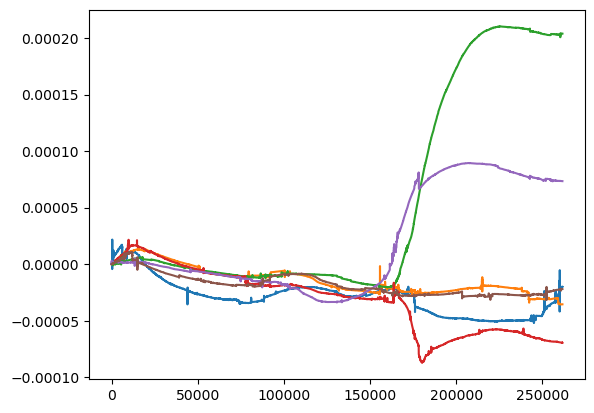

In [257]:
chid = 19

plt.plot(strain_L1[chid,:])
plt.plot(strain_L2[chid,:])
plt.plot(strain_L3[chid,:])
plt.plot(strain_L4[chid,:])
plt.plot(strain_L5[chid,:])
plt.plot(strain_L6[chid,:])

### Compute strain rate data (numpy gradient)

In [260]:
# COMPUTE STRAIN RATE
srate_L1 = strain_L1.copy()
for icha in range(ncha_L1):
    srate_L1[icha,:] = np.gradient(strain_L1[icha,:])

srate_L2 = strain_L2.copy()
for icha in range(ncha_L2):
    srate_L2[icha,:] = np.gradient(strain_L2[icha,:])

srate_L3 = strain_L3.copy()
for icha in range(ncha_L3):
    srate_L3[icha,:] = np.gradient(strain_L3[icha,:])
    
srate_L4 = strain_L4.copy()
for icha in range(ncha_L4):
    srate_L4[icha,:] = np.gradient(strain_L4[icha,:])
    
srate_L5 = strain_L5.copy()
for icha in range(ncha_L5):
    srate_L5[icha,:] = np.gradient(strain_L5[icha,:])
    
srate_L6 = strain_L6.copy()
for icha in range(ncha_L6):
    srate_L6[icha,:] = np.gradient(strain_L6[icha,:])


### Apply a 2D median filter on strain-rate data
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.medfilt2d.html#scipy.signal.medfilt2d




In [261]:
# MEDIAN FILTER FOR STRAIN RATE

kernel_size = [3,59]     # [nchannels, nseconds]

sratefilt_L1 = signal.medfilt2d(srate_L1, kernel_size=kernel_size)
sratefilt_L2 = signal.medfilt2d(srate_L2, kernel_size=kernel_size) 
sratefilt_L3 = signal.medfilt2d(srate_L3, kernel_size=kernel_size) 
sratefilt_L4 = signal.medfilt2d(srate_L4, kernel_size=kernel_size) 
sratefilt_L5 = signal.medfilt2d(srate_L5, kernel_size=kernel_size) 
sratefilt_L6 = signal.medfilt2d(srate_L6, kernel_size=kernel_size) 

## Import LiDAR DEM Data

In [264]:
#######################################################
########### LIDAR DEM CROSS SECTION DATA ##############
#######################################################

# Interpolated Nov 2020 DEM Locations to align with DAS channels
l1_chan = pd.read_csv('/Users/souellet/research/hollinhill/line1_chan.csv') # Resampled coordinates of FO section to align with number of channels (to attach to xarray) 
l2_chan = pd.read_csv('/Users/souellet/research/hollinhill/line2_chan.csv') # Resampled coordinates of FO section to align with number of channels (to attach to xarray) 
l3_chan = pd.read_csv('/Users/souellet/research/hollinhill/line3_chan.csv') # Resampled coordinates of FO section to align with number of channels (to attach to xarray) 
l4_chan = pd.read_csv('/Users/souellet/research/hollinhill/line4_chan.csv') # Resampled coordinates of FO section to align with number of channels (to attach to xarray)
l5_chan = pd.read_csv('/Users/souellet/research/hollinhill/line5_chan.csv') # Resampled coordinates of FO section to align with number of channels (to attach to xarray) 
l6_chan = pd.read_csv('/Users/souellet/research/hollinhill/line6_chan.csv') # Resampled coordinates of FO section to align with number of channels (to attach to xarray) 


# Interpolated May 2021 DEM Locations to align with DAS channels
l1_chan2 = pd.read_csv('/Users/souellet/research/hollinhill/line1_chan2.csv') # Resampled coordinates of FO section to align with number of channels (to attach to xarray) DONE
l2_chan2 = pd.read_csv('/Users/souellet/research/hollinhill/line2_chan2.csv') # Resampled coordinates of FO section to align with number of channels (to attach to xarray) TO DO
l3_chan2 = pd.read_csv('/Users/souellet/research/hollinhill/line3_chan2.csv') # Resampled coordinates of FO section to align with number of channels (to attach to xarray) TO DO
l4_chan2 = pd.read_csv('/Users/souellet/research/hollinhill/line4_chan2.csv') # Resampled coordinates of FO section to align with number of channels (to attach to xarray) TO DO
l5_chan2 = pd.read_csv('/Users/souellet/research/hollinhill/line5_chan2.csv') # Resampled coordinates of FO section to align with number of channels (to attach to xarray) TO DO
l6_chan2 = pd.read_csv('/Users/souellet/research/hollinhill/line6_chan2.csv') # Resampled coordinates of FO section to align with number of channels (to attach to xarray) TO DO

# Convert data into numpy array (to attach to channel info in xarray metatadata).

################################
### NOVEMBER 2020 Lidar DATA ###
################################

x1 = np.asarray(l1_chan['easting'])
y1 = np.asarray(l1_chan['northing'])
z1 = np.asarray(l1_chan['Z'])
X1 = np.asarray(l1_chan['X'])

x2 = np.asarray(l2_chan['easting'])
y2 = np.asarray(l2_chan['northing'])
z2 = np.asarray(l2_chan['Z'])
X2 = np.asarray(l2_chan['X'])

x3 = np.asarray(l3_chan['easting'])
y3 = np.asarray(l3_chan['northing'])
z3 = np.asarray(l3_chan['Z'])
X3 = np.asarray(l3_chan['X'])

x4 = np.asarray(l4_chan['easting'])
y4 = np.asarray(l4_chan['northing'])
z4 = np.asarray(l4_chan['Z'])
X4 = np.asarray(l4_chan['X'])

x5 = np.asarray(l5_chan['easting'])
y5 = np.asarray(l5_chan['northing'])
z5 = np.asarray(l5_chan['Z'])
X5 = np.asarray(l5_chan['X'])

x6 = np.asarray(l6_chan['easting'])
y6 = np.asarray(l6_chan['northing'])
z6 = np.asarray(l6_chan['Z'])
X6 = np.asarray(l6_chan['X'])

################################
##### MAY 2021 Lidar DATA ######
################################

x1_2 = np.asarray(l1_chan2['easting'])
y1_2 = np.asarray(l1_chan2['northing'])
z1_2 = np.asarray(l1_chan2['Z'])
X1_2 = np.asarray(l1_chan2['X'])

x2_2 = np.asarray(l2_chan2['easting'])
y2_2 = np.asarray(l2_chan2['northing'])
z2_2 = np.asarray(l2_chan2['Z'])
X2_2 = np.asarray(l2_chan2['X'])

x3_2 = np.asarray(l3_chan2['easting'])
y3_2 = np.asarray(l3_chan2['northing'])
z3_2 = np.asarray(l3_chan2['Z'])
X3_2 = np.asarray(l3_chan2['X'])

x4_2 = np.asarray(l4_chan2['easting'])
y4_2 = np.asarray(l4_chan2['northing'])
z4_2 = np.asarray(l4_chan2['Z'])
X4_2 = np.asarray(l4_chan2['X'])

x5_2 = np.asarray(l5_chan2['easting'])
y5_2 = np.asarray(l5_chan2['northing'])
z5_2 = np.asarray(l5_chan2['Z'])
X5_2 = np.asarray(l5_chan2['X'])

x6_2 = np.asarray(l6_chan2['easting'])
y6_2 = np.asarray(l6_chan2['northing'])
z6_2 = np.asarray(l6_chan2['Z'])
X6_2 = np.asarray(l6_chan2['X'])


## Import data into Xarray

We will import the following datasets into the xarray format:

1. Strain rate data with median filter (3cha, 59sec)
4. Strain data (no filter) for tight-buffered (strain_tb)


In [270]:
locs = np.arange(chend_L4,chstart_L4 - 1,-1) # update channel labelling (changes on even lines for channels beginning in opposite direction based on install config)
print(locs)

[1641 1640 1639 1638 1637 1636 1635 1634 1633 1632 1631 1630 1629 1628
 1627 1626 1625 1624 1623 1622 1621 1620 1619 1618 1617 1616 1615 1614
 1613 1612 1611 1610 1609 1608 1607 1606 1605 1604 1603 1602 1601 1600
 1599 1598 1597 1596 1595 1594 1593 1592 1591 1590 1589 1588 1587 1586
 1585 1584 1583 1582 1581 1580 1579 1578 1577 1576 1575 1574 1573 1572
 1571 1570 1569 1568 1567 1566 1565 1564 1563 1562 1561 1560 1559 1558
 1557 1556 1555 1554 1553 1552 1551 1550 1549 1548 1547 1546 1545 1544
 1543 1542 1541 1540 1539 1538 1537 1536 1535 1534 1533 1532 1531 1530
 1529 1528 1527 1526 1525 1524 1523 1522 1521 1520 1519 1518 1517 1516
 1515 1514 1513 1512 1511 1510 1509 1508 1507 1506 1505 1504 1503 1502
 1501 1500]


In [280]:
# LINE 1 XARRAY - STRAIN AND FILTERED STRAIN RATE
locs = np.arange(chstart_L1,chend_L1+1)
s1 = strain_L1.T.copy()
s1 = xr.DataArray(s1, coords=[timeS,locs],dims=["time","channels"])
srate1 = sratefilt_L1.T.copy()
srate1 = xr.DataArray(srate1, coords=[timeS,locs],dims=["time","channels"])

# LINE 2 XARRAY - STRAIN AND FILTERED STRAIN RATE
locs = np.arange(chstart_L2,chend_L2+1) # update channel labelling (changes on even lines for channels beginning in opposite direction based on install config)
s2 = strain_L2.T.copy()
s2 = xr.DataArray(s2, coords=[timeS,locs],dims=["time","channels"])
srate2 = sratefilt_L2.T.copy()
srate2 = xr.DataArray(srate2, coords=[timeS,locs],dims=["time","channels"])
s2 = s2.isel(channels=slice(None, None, -1))         # update channel labelling (changes on even lines for channels beginning in opposite direction based on install config)
srate2 = srate2.isel(channels=slice(None, None, -1)) # update channel labelling (changes on even lines for channels beginning in opposite direction based on install config)

# LINE 3 XARRAY - STRAIN AND FILTERED STRAIN RATE
locs = np.arange(chstart_L3,chend_L3+1)
s3 = strain_L3.T.copy()
s3 = xr.DataArray(s3, coords=[timeS,locs],dims=["time","channels"])
srate3 = sratefilt_L3.T.copy()
srate3 = xr.DataArray(srate3, coords=[timeS,locs],dims=["time","channels"])

# LINE 4 XARRAY - STRAIN AND FILTERED STRAIN RATE
locs = np.arange(chstart_L4,chend_L4+1) # update channel labelling (changes on even lines for channels beginning in opposite direction based on install config)
s4 = strain_L4.T.copy()
s4 = xr.DataArray(s4, coords=[timeS,locs],dims=["time","channels"])
srate4 = sratefilt_L4.T.copy()
srate4 = xr.DataArray(srate4, coords=[timeS,locs],dims=["time","channels"])
s4 = s4.isel(channels=slice(None, None, -1))         # update channel labelling (changes on even lines for channels beginning in opposite direction based on install config)
srate4 = srate4.isel(channels=slice(None, None, -1))

# LINE 5 XARRAY - STRAIN AND FILTERED STRAIN RATE
locs = np.arange(chstart_L5,chend_L5+1)
s5 = strain_L5.T.copy()
s5 = xr.DataArray(s5, coords=[timeS,locs],dims=["time","channels"])
srate5 = sratefilt_L5.T.copy()
srate5 = xr.DataArray(srate5, coords=[timeS,locs],dims=["time","channels"])

# LINE 6 XARRAY - STRAIN AND FILTERED STRAIN RATE
locs = np.arange(chstart_L6,chend_L6+1) # update channel labelling (changes on even lines for channels beginning in opposite direction based on install config)
s6 = strain_L6.T.copy()
s6 = xr.DataArray(s6, coords=[timeS,locs],dims=["time","channels"])
srate6 = sratefilt_L6.T.copy()
srate6 = xr.DataArray(srate6, coords=[timeS,locs],dims=["time","channels"])
s6 = s6.isel(channels=slice(None, None, -1))          # update channel labelling (changes on even lines for channels beginning in opposite direction based on install config)
srate6 = srate6.isel(channels=slice(None, None, -1))


In [281]:
# STRAIN METADATA


################################
### NOVEMBER 2020 Lidar DATA ###
################################

s1 = s1.assign_coords(x = ("channels",x1))
s1 = s1.assign_coords(y = ("channels",y1))
s1 = s1.assign_coords(z = ("channels",z1))
s1 = s1.assign_coords(X = ("channels",X1))

s2 = s2.assign_coords(x = ("channels",x2))
s2 = s2.assign_coords(y = ("channels",y2))
s2 = s2.assign_coords(z = ("channels",z2))
s2 = s2.assign_coords(X = ("channels",X2))

s3 = s3.assign_coords(x = ("channels",x3))
s3 = s3.assign_coords(y = ("channels",y3))
s3 = s3.assign_coords(z = ("channels",z3))
s3 = s3.assign_coords(X = ("channels",X3))

s4 = s4.assign_coords(x = ("channels",x4))
s4 = s4.assign_coords(y = ("channels",y4))
s4 = s4.assign_coords(z = ("channels",z4))
s4 = s4.assign_coords(X = ("channels",X4))

s5 = s5.assign_coords(x = ("channels",x5))
s5 = s5.assign_coords(y = ("channels",y5))
s5 = s5.assign_coords(z = ("channels",z5))
s5 = s5.assign_coords(X = ("channels",X5))

s6 = s6.assign_coords(x = ("channels",x6))
s6 = s6.assign_coords(y = ("channels",y6))
s6 = s6.assign_coords(z = ("channels",z6))
s6 = s6.assign_coords(X = ("channels",X6))

################################
##### MAY 2021 Lidar DATA ######
################################

s1 = s1.assign_coords(x2 = ("channels",x1_2))
s1 = s1.assign_coords(y2 = ("channels",y1_2))
s1 = s1.assign_coords(z2 = ("channels",z1_2))
s1 = s1.assign_coords(X2 = ("channels",X1_2))

s2 = s2.assign_coords(x2 = ("channels",x2_2))
s2 = s2.assign_coords(y2 = ("channels",y2_2))
s2 = s2.assign_coords(z2 = ("channels",z2_2))
s2 = s2.assign_coords(X2 = ("channels",X2_2))

s3 = s3.assign_coords(x2 = ("channels",x3_2))
s3 = s3.assign_coords(y2 = ("channels",y3_2))
s3 = s3.assign_coords(z2 = ("channels",z3_2))
s3 = s3.assign_coords(X2 = ("channels",X3_2))

s4 = s4.assign_coords(x2 = ("channels",x4_2))
s4 = s4.assign_coords(y2 = ("channels",y4_2))
s4 = s4.assign_coords(z2 = ("channels",z4_2))
s4 = s4.assign_coords(X2 = ("channels",X4_2))

s5 = s5.assign_coords(x2 = ("channels",x5_2))
s5 = s5.assign_coords(y2 = ("channels",y5_2))
s5 = s5.assign_coords(z2 = ("channels",z5_2))
s5 = s5.assign_coords(X2 = ("channels",X5_2))

s6 = s6.assign_coords(x2 = ("channels",x6_2))
s6 = s6.assign_coords(y2 = ("channels",y6_2))
s6 = s6.assign_coords(z2 = ("channels",z6_2))
s6 = s6.assign_coords(X2 = ("channels",X6_2))


#srate1 = srate1.drop_vars(["easting","northing","elevation"]) # IF NEEDING TO REMOVE ATTRIBUTE METADATA

s1.attrs["units"] = ""   # add attribute data
s1.attrs["coordinate system"] = "British Grid OSGB36 Datum"   # add attribute data

s2.attrs["units"] = ""   # add attribute data
s2.attrs["coordinate system"] = "British Grid OSGB36 Datum"   # add attribute data

s3.attrs["units"] = ""   # add attribute data
s3.attrs["coordinate system"] = "British Grid OSGB36 Datum"   # add attribute data

s4.attrs["units"] = ""   # add attribute data
s4.attrs["coordinate system"] = "British Grid OSGB36 Datum"   # add attribute data

s5.attrs["units"] = ""   # add attribute data
s5.attrs["coordinate system"] = "British Grid OSGB36 Datum"   # add attribute data

s6.attrs["units"] = ""   # add attribute data
s6.attrs["coordinate system"] = "British Grid OSGB36 Datum"   # add attribute data



In [282]:
# STRAIN RATE METADATA

################################
### NOVEMBER 2020 Lidar DATA ###
################################

srate1 = srate1.assign_coords(x = ("channels",x1))
srate1 = srate1.assign_coords(y = ("channels",y1))
srate1 = srate1.assign_coords(z = ("channels",z1))
srate1 = srate1.assign_coords(X = ("channels",X1))

srate2 = srate2.assign_coords(x = ("channels",x2))
srate2 = srate2.assign_coords(y = ("channels",y2))
srate2 = srate2.assign_coords(z = ("channels",z2))
srate2 = srate2.assign_coords(X = ("channels",X2))

srate3 = srate3.assign_coords(x = ("channels",x3))
srate3 = srate3.assign_coords(y = ("channels",y3))
srate3 = srate3.assign_coords(z = ("channels",z3))
srate3 = srate3.assign_coords(X = ("channels",X3))

srate4 = srate4.assign_coords(x = ("channels",x4))
srate4 = srate4.assign_coords(y = ("channels",y4))
srate4 = srate4.assign_coords(z = ("channels",z4))
srate4 = srate4.assign_coords(X = ("channels",X4))

srate5 = srate5.assign_coords(x = ("channels",x5))
srate5 = srate5.assign_coords(y = ("channels",y5))
srate5 = srate5.assign_coords(z = ("channels",z5))
srate5 = srate5.assign_coords(X = ("channels",X5))

srate6 = srate6.assign_coords(x = ("channels",x6))
srate6 = srate6.assign_coords(y = ("channels",y6))
srate6 = srate6.assign_coords(z = ("channels",z6))
srate6 = srate6.assign_coords(X = ("channels",X6))

################################
##### MAY 2021 Lidar DATA ######
################################

srate1 = srate1.assign_coords(x2 = ("channels",x1_2))
srate1 = srate1.assign_coords(y2 = ("channels",y1_2))
srate1 = srate1.assign_coords(z2 = ("channels",z1_2))
srate1 = srate1.assign_coords(X2 = ("channels",X1_2))

srate2 = srate2.assign_coords(x2 = ("channels",x2_2))
srate2 = srate2.assign_coords(y2 = ("channels",y2_2))
srate2 = srate2.assign_coords(z2 = ("channels",z2_2))
srate2 = srate2.assign_coords(X2 = ("channels",X2_2))

srate3 = srate3.assign_coords(x2 = ("channels",x3_2))
srate3 = srate3.assign_coords(y2 = ("channels",y3_2))
srate3 = srate3.assign_coords(z2 = ("channels",z3_2))
srate3 = srate3.assign_coords(X2 = ("channels",X3_2))

srate4 = srate4.assign_coords(x2 = ("channels",x4_2))
srate4 = srate4.assign_coords(y2 = ("channels",y4_2))
srate4 = srate4.assign_coords(z2 = ("channels",z4_2))
srate4 = srate4.assign_coords(X2 = ("channels",X4_2))

srate5 = srate5.assign_coords(x2 = ("channels",x5_2))
srate5 = srate5.assign_coords(y2 = ("channels",y5_2))
srate5 = srate5.assign_coords(z2 = ("channels",z5_2))
srate5 = srate5.assign_coords(X2 = ("channels",X5_2))

srate6 = srate6.assign_coords(x2 = ("channels",x6_2))
srate6 = srate6.assign_coords(y2 = ("channels",y6_2))
srate6 = srate6.assign_coords(z2 = ("channels",z6_2))
srate6 = srate6.assign_coords(X2 = ("channels",X6_2))

#srate1 = srate1.drop_vars(["easting","northing","elevation"]) # IF NEEDING TO REMOVE ATTRIBUTE METADATA

srate1.attrs["units"] = "sec -1"   # add attribute data
srate1.attrs["coordinate system"] = "British Grid OSGB36 Datum"   # add attribute data

srate2.attrs["units"] = "sec -1"   # add attribute data
srate2.attrs["coordinate system"] = "British Grid OSGB36 Datum"   # add attribute data

srate3.attrs["units"] = "sec -1"   # add attribute data
srate3.attrs["coordinate system"] = "British Grid OSGB36 Datum"   # add attribute data

srate4.attrs["units"] = "sec -1"   # add attribute data
srate4.attrs["coordinate system"] = "British Grid OSGB36 Datum"   # add attribute data

srate5.attrs["units"] = "sec -1"   # add attribute data
srate5.attrs["coordinate system"] = "British Grid OSGB36 Datum"   # add attribute data

srate6.attrs["units"] = "sec -1"   # add attribute data
srate6.attrs["coordinate system"] = "British Grid OSGB36 Datum"   # add attribute data



### Reindex Xarray such that data gaps are shown

In [283]:
# Continuous time vector. Will be used for reindexing. Trimmed the initial 10 seconds to align with xarray start time.
timevec = np.arange(times[10],times[-1]+1,dtype='datetime64[s]')  # Reminder that initial 10 seconds trimmed, therefore times[10] represents start time

s1 = s1.reindex(time=timevec)
s2 = s2.reindex(time=timevec)
s3 = s3.reindex(time=timevec)
s4 = s4.reindex(time=timevec)
s5 = s5.reindex(time=timevec)
s6 = s6.reindex(time=timevec)

srate1 = srate1.reindex(time=timevec)
srate2 = srate2.reindex(time=timevec)
srate3 = srate3.reindex(time=timevec)
srate4 = srate4.reindex(time=timevec)
srate5 = srate5.reindex(time=timevec)
srate6 = srate6.reindex(time=timevec)


## Save Xarray data to disk

In [286]:
s1.to_netcdf("s1.nc") # save strain xarray data 
s2.to_netcdf("s2.nc") # save strain xarray data 
s3.to_netcdf("s3.nc") # save strain xarray data 
s4.to_netcdf("s4.nc") # save strain xarray data 
s5.to_netcdf("s5.nc") # save strain xarray data 
s6.to_netcdf("s6.nc") # save strain xarray data 

srate1.to_netcdf("srate1.nc") # save strain rate xarray data
srate2.to_netcdf("srate2.nc") # save strain rate xarray data 
srate3.to_netcdf("srate3.nc") # save strain rate xarray data 
srate4.to_netcdf("srate4.nc") # save strain rate xarray data
srate5.to_netcdf("srate5.nc") # save strain rate xarray data
srate6.to_netcdf("srate6.nc") # save strain rate xarray data
